In [ ]:
!pip install mediapipe

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 2.6 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of opencv-contrib-python to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.6/35.6 MB 29.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.0/18.0 MB 46.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 17.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.1/69.1 MB 9.1 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 5.29.5
    Uninstalling protobuf-5.29.5:
      Successfully uninstalled protobuf-5.29.5
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
  Attempting uninstall: opencv-contrib-python
    Found existing installation: opencv-contrib-python 4.12.0.88
    Uninstalling opencv

## Manipulate data

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("ayuraj/asl-dataset")

print("Path to dataset files:", path)

100%|██████████| 56.9M/56.9M [00:00<00:00, 244MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/ayuraj/asl-dataset/versions/1


In [ ]:
import os
import pandas as pd
import string

image_paths = []
labels = []

dataset_path = path+"/asl_dataset"

# Create a set of valid labels (A-Z)
valid_labels = set(string.ascii_lowercase)


for label_folder_name in os.listdir(dataset_path):
    label_folder_path = os.path.join(dataset_path, label_folder_name)

    # Check if the folder is a directory and if the label is in the valid_labels set
    if os.path.isdir(label_folder_path) and label_folder_name in valid_labels:
        for image_file_name in os.listdir(label_folder_path):
            image_file_path = os.path.join(label_folder_path, image_file_name)

            if os.path.isfile(image_file_path):
                image_paths.append(image_file_path)
                labels.append(label_folder_name)

print(f"Collected {len(image_paths)} image paths and {len(labels)} labels.")

Collected 1815 image paths and 1815 labels.


In [ ]:
import pandas as pd
import os

# Create a DataFrame from the collected image_paths and labels
df = pd.DataFrame({'image_path': image_paths, 'label': labels})

# --- Modification to make each label equal ---
# Determine the minimum number of images per label
label_counts = df['label'].value_counts()
min_samples_per_label = label_counts.min()

# Set the number of samples per label to the minimum number of samples available
num_samples_per_label = min_samples_per_label

# Sample an equal number of images from each label
df_sampled = df.groupby('label').apply(lambda x: x.sample(n=num_samples_per_label, random_state=42)).reset_index(drop=True)

print(f"Reduced the dataset to {len(df_sampled)} samples with {num_samples_per_label} samples per label.")
# --- End of modification ---


# Define the filename for the CSV file
csv_filename = "image_labels_sampled_balanced.csv" # Changed filename to reflect balancing

# Save the sampled DataFrame to a CSV file
df_sampled.to_csv(csv_filename, index=False)

print(f"Sampled and balanced DataFrame created and saved to {csv_filename}")
display(df_sampled.head())
display(df_sampled['label'].value_counts()) # Display value counts to verify balancing

Reduced the dataset to 1690 samples with 65 samples per label.
Sampled and balanced DataFrame created and saved to image_labels_sampled_balanced.csv


/tmp/ipython-input-3322319827.py:16: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_sampled = df.groupby('label').apply(lambda x: x.sample(n=num_samples_per_label, random_state=42)).reset_index(drop=True)


,image_path,label
0,/root/.cache/kagglehub/datasets/ayuraj/asl-dat...,a
1,/root/.cache/kagglehub/datasets/ayuraj/asl-dat...,a
2,/root/.cache/kagglehub/datasets/ayuraj/asl-dat...,a
3,/root/.cache/kagglehub/datasets/ayuraj/asl-dat...,a
4,/root/.cache/kagglehub/datasets/ayuraj/asl-dat...,a


,count
label,
a,65
b,65
c,65
d,65
e,65
f,65
g,65
h,65
i,65


## train model

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
import time
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np


def train_model(model, train_loader, val_loader, num_epochs=50,
                learning_rate=0.001, device='cuda', save_path='best_model.pth',
                patience=10):
    """
    Train the ASL classifier with early stopping

    Args:
        model: ASL classifier model
        train_loader: Training data loader
        val_loader: Validation data loader
        num_epochs: Maximum number of epochs
        learning_rate: Initial learning rate
        device: 'cuda' or 'cpu'
        save_path: Path to save best model
        patience: Early stopping patience

    Returns:
        history: Dictionary with training history
    """
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.5,
                                  patience=5)

    history = {
        'train_loss': [],
        'train_acc': [],
        'val_loss': [],
        'val_acc': [],
        'learning_rate': []
    }

    best_val_acc = 0.0
    patience_counter = 0

    print("\n" + "="*60)
    print("TRAINING START")
    print("="*60)

    for epoch in range(num_epochs):
        start_time = time.time()

        # ===== TRAINING PHASE =====
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0

        train_bar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Train]')
        for inputs, labels in train_bar:
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Backward pass
            loss.backward()
            optimizer.step()

            # Statistics
            train_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()

            # Update progress bar
            train_bar.set_postfix({
                'loss': f'{loss.item():.4f}',
                'acc': f'{100.*train_correct/train_total:.2f}%'
            })

        train_loss = train_loss / train_total
        train_acc = 100. * train_correct / train_total

        # ===== VALIDATION PHASE =====
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            val_bar = tqdm(val_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Val]')
            for inputs, labels in val_bar:
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)

                val_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs.data, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

                val_bar.set_postfix({
                    'loss': f'{loss.item():.4f}',
                    'acc': f'{100.*val_correct/val_total:.2f}%'
                })

        val_loss = val_loss / val_total
        val_acc = 100. * val_correct / val_total

        # Update learning rate scheduler
        scheduler.step(val_acc)
        current_lr = optimizer.param_groups[0]['lr']

        # Save history
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        history['learning_rate'].append(current_lr)

        epoch_time = time.time() - start_time

        # Print epoch summary
        print(f'\nEpoch {epoch+1}/{num_epochs} - {epoch_time:.2f}s')
        print(f'Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%')
        print(f'Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%')
        print(f'Learning Rate: {current_lr:.6f}')

        # Save best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'val_acc': val_acc,
            }, save_path)
            print(f'✓ Best model saved! (Val Acc: {val_acc:.2f}%)')
            patience_counter = 0
        else:
            patience_counter += 1
            print(f'No improvement. Patience: {patience_counter}/{patience}')

        # Early stopping
        if patience_counter >= patience:
            print(f'\nEarly stopping triggered after {epoch+1} epochs')
            break

        print('-' * 60)

    print("\n" + "="*60)
    print("TRAINING COMPLETE")
    print(f"Best Validation Accuracy: {best_val_acc:.2f}%")
    print("="*60)

    return history


def evaluate_model(model, test_loader, device='cuda', label_encoder=None):
    """
    Evaluate model on test set

    Returns:
        accuracy: Test accuracy percentage
        loss: Average test loss
        predictions: All predictions
        true_labels: All true labels
    """
    model.eval()
    criterion = nn.CrossEntropyLoss()

    test_loss = 0.0
    all_predictions = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in tqdm(test_loader, desc='Evaluating'):
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            test_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)

            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    test_loss = test_loss / len(test_loader.dataset)
    accuracy = 100. * np.sum(np.array(all_predictions) == np.array(all_labels)) / len(all_labels)

    return accuracy, test_loss, np.array(all_predictions), np.array(all_labels)


def plot_training_history(history, save_path='training_history.png'):
    """Plot training and validation metrics"""
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))

    epochs = range(1, len(history['train_loss']) + 1)

    # Loss plot
    axes[0].plot(epochs, history['train_loss'], 'b-', label='Train Loss')
    axes[0].plot(epochs, history['val_loss'], 'r-', label='Val Loss')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].set_title('Training and Validation Loss')
    axes[0].legend()
    axes[0].grid(True)

    # Accuracy plot
    axes[1].plot(epochs, history['train_acc'], 'b-', label='Train Acc')
    axes[1].plot(epochs, history['val_acc'], 'r-', label='Val Acc')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Accuracy (%)')
    axes[1].set_title('Training and Validation Accuracy')
    axes[1].legend()
    axes[1].grid(True)

    # Learning rate plot
    axes[2].plot(epochs, history['learning_rate'], 'g-')
    axes[2].set_xlabel('Epoch')
    axes[2].set_ylabel('Learning Rate')
    axes[2].set_title('Learning Rate Schedule')
    axes[2].set_yscale('log')
    axes[2].grid(True)

    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    print(f"Training history plot saved to {save_path}")
    plt.show()


def plot_confusion_matrix(true_labels, predictions, class_names,
                         save_path='confusion_matrix.png'):
    """Plot confusion matrix"""
    cm = confusion_matrix(true_labels, predictions)

    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    print(f"Confusion matrix saved to {save_path}")
    plt.show()


def print_classification_report(true_labels, predictions, class_names):
    """Print detailed classification report"""
    print("\n" + "="*60)
    print("CLASSIFICATION REPORT")
    print("="*60)
    report = classification_report(true_labels, predictions,
                                   target_names=class_names, digits=4)
    print(report)

    # Calculate per-class accuracy
    cm = confusion_matrix(true_labels, predictions)
    per_class_acc = cm.diagonal() / cm.sum(axis=1)

    print("\nPer-Class Accuracy:")
    print("-" * 40)
    for i, (class_name, acc) in enumerate(zip(class_names, per_class_acc)):
        print(f"{class_name}: {acc*100:.2f}%")

    # Find worst performing classes
    worst_indices = np.argsort(per_class_acc)[:5]
    print("\nWorst Performing Classes:")
    print("-" * 40)
    for idx in worst_indices:
        print(f"{class_names[idx]}: {per_class_acc[idx]*100:.2f}%")


def load_best_model(model, checkpoint_path='best_asl_model.pth', device='cuda'):
    """Load best model checkpoint"""
    checkpoint = torch.load(checkpoint_path, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    model = model.to(device)
    print(f"Model loaded from {checkpoint_path}")
    print(f"Best validation accuracy: {checkpoint['val_acc']:.2f}%")
    return model


# ==================== COMPLETE EVALUATION PIPELINE ====================

def full_evaluation(model, test_loader, label_encoder, device='cuda'):
    """Run complete evaluation pipeline"""
    print("\n" + "="*60)
    print("STARTING FULL EVALUATION")
    print("="*60)

    # Evaluate
    test_acc, test_loss, predictions, true_labels = evaluate_model(
        model, test_loader, device
    )

    print(f"\nTest Accuracy: {test_acc:.2f}%")
    print(f"Test Loss: {test_loss:.4f}")

    # Get class names
    class_names = label_encoder.classes_

    # Print classification report
    print_classification_report(true_labels, predictions, class_names)

    # Plot confusion matrix
    plot_confusion_matrix(true_labels, predictions, class_names)

    print("\n" + "="*60)
    print("EVALUATION COMPLETE")
    print("="*60)

    return test_acc, test_loss

In [ ]:
# !rm -r "/content/skeletonized_images_ultra_enhanced"

In [ ]:
import cv2
import mediapipe as mp
import numpy as np
import os
from pathlib import Path
import pickle
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from torchvision import models # Import torchvision models

# ==================== DATA PREPROCESSING ====================

class ASLDataPreprocessor:
    def __init__(self, min_detection_confidence=0.3):
        self.mp_hands = mp.solutions.hands
        self.hands = self.mp_hands.Hands(
            static_image_mode=True,
            max_num_hands=1,
            min_detection_confidence=min_detection_confidence,
            min_tracking_confidence=0.3,
            model_complexity=1
        )

    def add_padding(self, image, padding_percent=0.2):
        """Add padding around image to help MediaPipe detection"""
        h, w = image.shape[:2]
        pad_h = int(h * padding_percent)
        pad_w = int(w * padding_percent)

        # Add white border
        padded = cv2.copyMakeBorder(
            image, pad_h, pad_h, pad_w, pad_w,
            cv2.BORDER_CONSTANT, value=[255, 255, 255]
        )
        return padded

    def extract_landmarks(self, image_path, add_padding_flag=True):
        """Extract hand landmarks from image using MediaPipe"""
        image = cv2.imread(str(image_path))
        if image is None:
            return None

        # Add padding to help detection
        if add_padding_flag:
            image = self.add_padding(image, padding_percent=0.2)

        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        results = self.hands.process(image_rgb)

        if not results.multi_hand_landmarks:
            return None

        # Get first hand detected
        hand_landmarks = results.multi_hand_landmarks[0]

        # Extract 21 landmarks (x, y, z) = 63 features
        landmarks = []
        for landmark in hand_landmarks.landmark:
            landmarks.extend([landmark.x, landmark.y, landmark.z])

        return np.array(landmarks, dtype=np.float32)

    def normalize_landmarks(self, landmarks):
        """Normalize landmarks relative to wrist and hand size"""
        if landmarks is None:
            return None

        landmarks = landmarks.reshape(21, 3)

        # Get wrist position (landmark 0)
        wrist = landmarks[0]

        # Translate to wrist origin
        landmarks = landmarks - wrist

        # Calculate hand size (max distance from wrist)
        distances = np.linalg.norm(landmarks, axis=1)
        hand_size = np.max(distances)

        # Normalize by hand size (avoid division by zero)
        if hand_size > 0:
            landmarks = landmarks / hand_size

        return landmarks.flatten()

    def augment_landmarks(self, landmarks, noise_level=0.02):
        """Add slight noise for data augmentation"""
        noise = np.random.normal(0, noise_level, landmarks.shape)
        return landmarks + noise

    def process_dataset(self, dataset_path, augment=True, augment_factor=2,
                       filter_alphabet_only=True):
        """
        Process entire dataset folder structure:
        dataset_path/
            A/
                img1.jpg
                img2.jpg
            B/
                img1.jpg
            ...

        Args:
            filter_alphabet_only: If True, only process A-Z folders (skip numbers)
        """
        dataset_path = Path(dataset_path)
        X = []
        y = []

        failed_images = 0
        valid_letters = set('ABCDEFGHIJKLMNOPQRSTUVWXYZ')

        # Process each letter folder
        for letter_folder in sorted(dataset_path.iterdir()):
            if not letter_folder.is_dir():
                continue

            letter = letter_folder.name.upper()

            # Filter out non-alphabet folders if requested
            if filter_alphabet_only and letter not in valid_letters:
                print(f"Skipping non-alphabet folder: {letter}")
                continue

            print(f"Processing letter: {letter}")

            # Process each image in the folder
            for img_path in list(letter_folder.glob('*.jpg')) + list(letter_folder.glob('*.png')) + list(letter_folder.glob('*.jpeg')):
                landmarks = self.extract_landmarks(img_path, add_padding_flag=True)

                if landmarks is None:
                    failed_images += 1
                    continue

                # Normalize landmarks
                normalized = self.normalize_landmarks(landmarks)

                if normalized is not None:
                    X.append(normalized)
                    y.append(letter)

                    # Data augmentation
                    if augment:
                        for _ in range(augment_factor):
                            augmented = self.augment_landmarks(normalized)
                            X.append(augmented)
                            y.append(letter)

        print(f"\nProcessing complete!")
        print(f"Successfully processed: {len(X)} samples")
        print(f"Failed to detect hands: {failed_images} images")

        return np.array(X), np.array(y)

    def save_processed_data(self, X, y, output_path='processed_data.pkl'):
        """Save processed data to file"""
        with open(output_path, 'wb') as f:
            pickle.dump({'X': X, 'y': y}, f)
        print(f"Data saved to {output_path}")

    def load_processed_data(self, input_path='processed_data.pkl'):
        """Load processed data from file"""
        with open(input_path, 'rb') as f:
            data = pickle.load(f)
        return data['X'], data['y']




    def close(self):
        self.hands.close()


# ==================== PYTORCH DATASET ====================

class ASLDataset(Dataset):
    def __init__(self, X, y, label_encoder=None):
        self.X = torch.FloatTensor(X)

        # Encode labels to integers
        if label_encoder is None:
            self.label_encoder = LabelEncoder()
            self.y = torch.LongTensor(self.label_encoder.fit_transform(y))
        else:
            self.label_encoder = label_encoder
            self.y = torch.LongTensor(self.label_encoder.transform(y))

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]


# ==================== MODEL ARCHITECTURE ====================

class ASLClassifier(nn.Module):
    def __init__(self, num_classes=26):
        super(ASLClassifier, self).__init__()
        # Load pre-trained ResNet18
        self.resnet = models.resnet18(weights='ResNet18_Weights.DEFAULT')

        # Replace the input layer to accept 63 features instead of 3 channels
        # This requires modifying the first convolutional layer
        original_conv1 = self.resnet.conv1
        self.resnet.conv1 = nn.Conv2d(1, original_conv1.out_channels,
                                      kernel_size=original_conv1.kernel_size,
                                      stride=original_conv1.stride,
                                      padding=original_conv1.padding,
                                      bias=original_conv1.bias)

        # Replace the final fully connected layer
        num_ftrs = self.resnet.fc.in_features
        self.resnet.fc = nn.Linear(num_ftrs, num_classes)

    def forward(self, x):
        # Reshape input to be 4D (batch_size, channels, height, width)
        # Since we have 63 features, we can treat this as 63 channels of 1x1 data
        # Or reshape to something like (batch_size, 1, 63, 1) or (batch_size, 1, 7, 9) etc.
        # For simplicity, let's try reshaping to (batch_size, 1, 63, 1) and see if ResNet handles it.
        # A more standard approach might be to use a different backbone or a custom head
        # after the initial features. However, let's try this first.
        batch_size = x.size(0)
        x = x.view(batch_size, 1, 63, 1) # Reshape for ResNet input

        x = self.resnet(x)
        return x

=== Starting Data Preprocessing ===
Skipping non-alphabet folder: 0
Skipping non-alphabet folder: 1
Skipping non-alphabet folder: 2
Skipping non-alphabet folder: 3
Skipping non-alphabet folder: 4
Skipping non-alphabet folder: 5
Skipping non-alphabet folder: 6
Skipping non-alphabet folder: 7
Skipping non-alphabet folder: 8
Skipping non-alphabet folder: 9
Processing letter: A
Skipping non-alphabet folder: ASL_DATASET
Processing letter: B
Processing letter: C
Processing letter: D
Processing letter: E
Processing letter: F
Processing letter: G
Processing letter: H
Processing letter: I
Processing letter: J
Processing letter: K
Processing letter: L
Processing letter: M
Processing letter: N
Processing letter: O
Processing letter: P
Processing letter: Q
Processing letter: R
Processing letter: S
Processing letter: T
Processing letter: U
Processing letter: V
Processing letter: W
Processing letter: X
Processing letter: Y
Processing letter: Z

Processing complete!
Successfully processed: 4740 sampl

Epoch 1/50 [Val]: 100%|██████████| 12/12 [00:00<00:00, 93.58it/s, loss=3.5931, acc=17.02%]



Epoch 1/50 - 2.79s
Train Loss: 0.5811 | Train Acc: 83.57%
Val Loss: 3.1504 | Val Acc: 17.02%
Learning Rate: 0.001000
✓ Best model saved! (Val Acc: 17.02%)
------------------------------------------------------------


Epoch 2/50 [Val]: 100%|██████████| 12/12 [00:00<00:00, 146.00it/s, loss=0.0008, acc=92.69%]



Epoch 2/50 - 1.18s
Train Loss: 0.2089 | Train Acc: 93.67%
Val Loss: 0.2163 | Val Acc: 92.69%
Learning Rate: 0.001000
✓ Best model saved! (Val Acc: 92.69%)
------------------------------------------------------------


Epoch 3/50 [Val]: 100%|██████████| 12/12 [00:00<00:00, 113.37it/s, loss=0.0021, acc=91.70%]



Epoch 3/50 - 1.28s
Train Loss: 0.1669 | Train Acc: 94.97%
Val Loss: 0.3341 | Val Acc: 91.70%
Learning Rate: 0.001000
No improvement. Patience: 1/10
------------------------------------------------------------


Epoch 4/50 [Val]: 100%|██████████| 12/12 [00:00<00:00, 144.12it/s, loss=0.0001, acc=93.67%]



Epoch 4/50 - 1.20s
Train Loss: 0.1450 | Train Acc: 95.72%
Val Loss: 0.1786 | Val Acc: 93.67%
Learning Rate: 0.001000
✓ Best model saved! (Val Acc: 93.67%)
------------------------------------------------------------


Epoch 5/50 [Val]: 100%|██████████| 12/12 [00:00<00:00, 143.80it/s, loss=0.0023, acc=95.50%]



Epoch 5/50 - 1.16s
Train Loss: 0.0974 | Train Acc: 97.20%
Val Loss: 0.1626 | Val Acc: 95.50%
Learning Rate: 0.001000
✓ Best model saved! (Val Acc: 95.50%)
------------------------------------------------------------


Epoch 6/50 [Val]: 100%|██████████| 12/12 [00:00<00:00, 132.67it/s, loss=0.0019, acc=93.53%]



Epoch 6/50 - 1.17s
Train Loss: 0.1320 | Train Acc: 96.50%
Val Loss: 0.1993 | Val Acc: 93.53%
Learning Rate: 0.001000
No improvement. Patience: 1/10
------------------------------------------------------------


Epoch 7/50 [Val]: 100%|██████████| 12/12 [00:00<00:00, 149.23it/s, loss=0.0008, acc=94.80%]



Epoch 7/50 - 1.14s
Train Loss: 0.1127 | Train Acc: 97.14%
Val Loss: 0.1701 | Val Acc: 94.80%
Learning Rate: 0.001000
No improvement. Patience: 2/10
------------------------------------------------------------


Epoch 8/50 [Val]: 100%|██████████| 12/12 [00:00<00:00, 141.41it/s, loss=0.0000, acc=98.73%]



Epoch 8/50 - 1.15s
Train Loss: 0.0707 | Train Acc: 98.16%
Val Loss: 0.0587 | Val Acc: 98.73%
Learning Rate: 0.001000
✓ Best model saved! (Val Acc: 98.73%)
------------------------------------------------------------


Epoch 9/50 [Val]: 100%|██████████| 12/12 [00:00<00:00, 150.93it/s, loss=0.0000, acc=99.02%]



Epoch 9/50 - 1.14s
Train Loss: 0.0494 | Train Acc: 98.61%
Val Loss: 0.0384 | Val Acc: 99.02%
Learning Rate: 0.001000
✓ Best model saved! (Val Acc: 99.02%)
------------------------------------------------------------


Epoch 10/50 [Val]: 100%|██████████| 12/12 [00:00<00:00, 133.90it/s, loss=0.0006, acc=98.45%]



Epoch 10/50 - 1.16s
Train Loss: 0.0296 | Train Acc: 99.25%
Val Loss: 0.0451 | Val Acc: 98.45%
Learning Rate: 0.001000
No improvement. Patience: 1/10
------------------------------------------------------------


Epoch 11/50 [Val]: 100%|██████████| 12/12 [00:00<00:00, 145.49it/s, loss=0.0023, acc=96.06%]



Epoch 11/50 - 1.15s
Train Loss: 0.0633 | Train Acc: 98.19%
Val Loss: 0.1324 | Val Acc: 96.06%
Learning Rate: 0.001000
No improvement. Patience: 2/10
------------------------------------------------------------


Epoch 12/50 [Val]: 100%|██████████| 12/12 [00:00<00:00, 123.20it/s, loss=0.0008, acc=98.45%]



Epoch 12/50 - 1.23s
Train Loss: 0.0718 | Train Acc: 98.07%
Val Loss: 0.0814 | Val Acc: 98.45%
Learning Rate: 0.001000
No improvement. Patience: 3/10
------------------------------------------------------------


Epoch 13/50 [Val]: 100%|██████████| 12/12 [00:00<00:00, 143.99it/s, loss=0.0002, acc=97.33%]



Epoch 13/50 - 1.25s
Train Loss: 0.0514 | Train Acc: 98.52%
Val Loss: 0.0936 | Val Acc: 97.33%
Learning Rate: 0.001000
No improvement. Patience: 4/10
------------------------------------------------------------


Epoch 14/50 [Val]: 100%|██████████| 12/12 [00:00<00:00, 146.72it/s, loss=0.0020, acc=95.78%]



Epoch 14/50 - 1.15s
Train Loss: 0.0727 | Train Acc: 98.28%
Val Loss: 0.1311 | Val Acc: 95.78%
Learning Rate: 0.001000
No improvement. Patience: 5/10
------------------------------------------------------------


Epoch 15/50 [Val]: 100%|██████████| 12/12 [00:00<00:00, 145.48it/s, loss=0.0006, acc=98.45%]



Epoch 15/50 - 1.16s
Train Loss: 0.0511 | Train Acc: 98.49%
Val Loss: 0.0549 | Val Acc: 98.45%
Learning Rate: 0.000500
No improvement. Patience: 6/10
------------------------------------------------------------


Epoch 16/50 [Val]: 100%|██████████| 12/12 [00:00<00:00, 143.96it/s, loss=0.0003, acc=99.30%]



Epoch 16/50 - 1.17s
Train Loss: 0.0204 | Train Acc: 99.25%
Val Loss: 0.0354 | Val Acc: 99.30%
Learning Rate: 0.000500
✓ Best model saved! (Val Acc: 99.30%)
------------------------------------------------------------


Epoch 17/50 [Val]: 100%|██████████| 12/12 [00:00<00:00, 144.55it/s, loss=0.0002, acc=99.58%]



Epoch 17/50 - 1.17s
Train Loss: 0.0093 | Train Acc: 99.70%
Val Loss: 0.0259 | Val Acc: 99.58%
Learning Rate: 0.000500
✓ Best model saved! (Val Acc: 99.58%)
------------------------------------------------------------


Epoch 18/50 [Val]: 100%|██████████| 12/12 [00:00<00:00, 147.44it/s, loss=0.0002, acc=99.58%]



Epoch 18/50 - 1.15s
Train Loss: 0.0038 | Train Acc: 99.91%
Val Loss: 0.0261 | Val Acc: 99.58%
Learning Rate: 0.000500
No improvement. Patience: 1/10
------------------------------------------------------------


Epoch 19/50 [Val]: 100%|██████████| 12/12 [00:00<00:00, 146.26it/s, loss=0.0001, acc=99.30%]



Epoch 19/50 - 1.15s
Train Loss: 0.0060 | Train Acc: 99.79%
Val Loss: 0.0332 | Val Acc: 99.30%
Learning Rate: 0.000500
No improvement. Patience: 2/10
------------------------------------------------------------


Epoch 20/50 [Val]: 100%|██████████| 12/12 [00:00<00:00, 137.98it/s, loss=0.0001, acc=98.31%]



Epoch 20/50 - 1.18s
Train Loss: 0.0043 | Train Acc: 99.85%
Val Loss: 0.0853 | Val Acc: 98.31%
Learning Rate: 0.000500
No improvement. Patience: 3/10
------------------------------------------------------------


Epoch 21/50 [Val]: 100%|██████████| 12/12 [00:00<00:00, 127.02it/s, loss=0.0001, acc=99.44%]



Epoch 21/50 - 1.18s
Train Loss: 0.0044 | Train Acc: 99.94%
Val Loss: 0.0421 | Val Acc: 99.44%
Learning Rate: 0.000500
No improvement. Patience: 4/10
------------------------------------------------------------


Epoch 22/50 [Val]: 100%|██████████| 12/12 [00:00<00:00, 134.78it/s, loss=0.0003, acc=99.30%]



Epoch 22/50 - 1.25s
Train Loss: 0.0203 | Train Acc: 99.58%
Val Loss: 0.0525 | Val Acc: 99.30%
Learning Rate: 0.000500
No improvement. Patience: 5/10
------------------------------------------------------------


Epoch 23/50 [Val]: 100%|██████████| 12/12 [00:00<00:00, 142.94it/s, loss=0.0002, acc=99.44%]



Epoch 23/50 - 1.25s
Train Loss: 0.0086 | Train Acc: 99.76%
Val Loss: 0.0314 | Val Acc: 99.44%
Learning Rate: 0.000250
No improvement. Patience: 6/10
------------------------------------------------------------


Epoch 24/50 [Val]: 100%|██████████| 12/12 [00:00<00:00, 147.41it/s, loss=0.0001, acc=99.44%]



Epoch 24/50 - 1.15s
Train Loss: 0.0018 | Train Acc: 99.94%
Val Loss: 0.0342 | Val Acc: 99.44%
Learning Rate: 0.000250
No improvement. Patience: 7/10
------------------------------------------------------------


Epoch 25/50 [Val]: 100%|██████████| 12/12 [00:00<00:00, 142.70it/s, loss=0.0001, acc=99.44%]



Epoch 25/50 - 1.14s
Train Loss: 0.0011 | Train Acc: 99.97%
Val Loss: 0.0401 | Val Acc: 99.44%
Learning Rate: 0.000250
No improvement. Patience: 8/10
------------------------------------------------------------


Epoch 26/50 [Val]: 100%|██████████| 12/12 [00:00<00:00, 146.85it/s, loss=0.0000, acc=99.44%]



Epoch 26/50 - 1.17s
Train Loss: 0.0039 | Train Acc: 99.91%
Val Loss: 0.0386 | Val Acc: 99.44%
Learning Rate: 0.000250
No improvement. Patience: 9/10
------------------------------------------------------------


Epoch 27/50 [Val]: 100%|██████████| 12/12 [00:00<00:00, 145.46it/s, loss=0.0001, acc=99.30%]



Epoch 27/50 - 1.19s
Train Loss: 0.0011 | Train Acc: 100.00%
Val Loss: 0.0406 | Val Acc: 99.30%
Learning Rate: 0.000250
No improvement. Patience: 10/10

Early stopping triggered after 27 epochs

TRAINING COMPLETE
Best Validation Accuracy: 99.58%

=== Final Evaluation on Test Set ===


Evaluating: 100%|██████████| 12/12 [00:00<00:00, 187.57it/s]


Test Accuracy: 99.16%
Test Loss: 0.0691
Training history plot saved to training_history.png


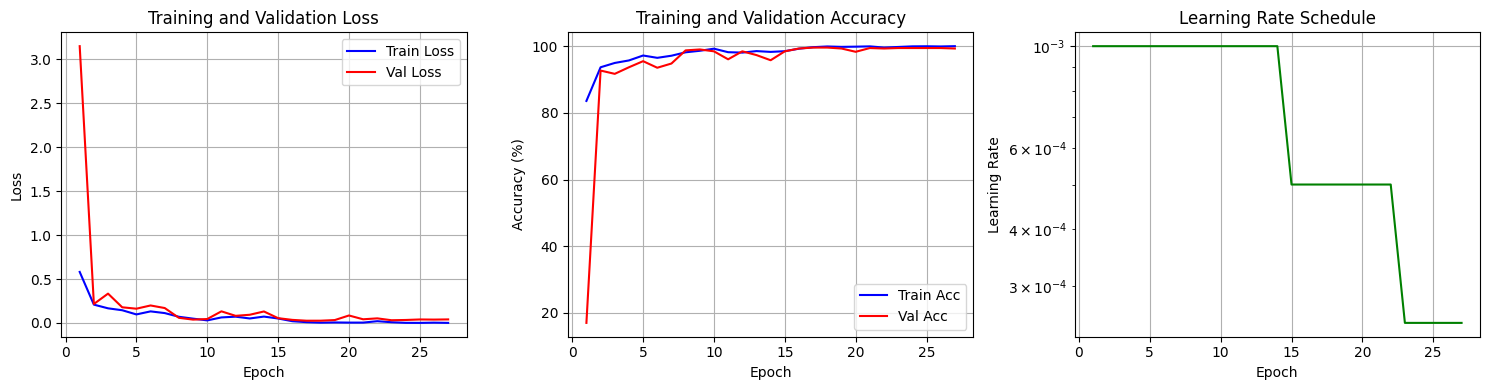

In [ ]:
# ==================== USAGE EXAMPLE ====================

if __name__ == "__main__":
    seed = 12345
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
    # Step 1: Preprocess dataset
    print("=== Starting Data Preprocessing ===")
    preprocessor = ASLDataPreprocessor()

    # Process your dataset (adjust path)
    dataset_path = dataset_path  # Change this to your dataset path
    X, y = preprocessor.process_dataset(dataset_path, augment=True, augment_factor=2)

    # Save processed data
    preprocessor.save_processed_data(X, y, 'asl_processed.pkl')
    preprocessor.close()

    # Step 2: Split data with minimum samples filter
    print("\n=== Splitting Dataset ===")

    # Filter out classes with too few samples
    min_samples_per_class = 10  # Minimum 10 samples to keep a class
    class_counts = {}
    for label in y:
        class_counts[label] = class_counts.get(label, 0) + 1

    # Identify classes to keep
    valid_classes = {label for label, count in class_counts.items() if count >= min_samples_per_class}

    if len(valid_classes) < len(class_counts):
        removed = set(class_counts.keys()) - valid_classes
        print(f"⚠ Removing {len(removed)} classes with < {min_samples_per_class} samples: {sorted(removed)}")

        # Filter dataset
        mask = np.array([label in valid_classes for label in y])
        X = X[mask]
        y = y[mask]

        print(f"Remaining samples: {len(X)}")
        print(f"Remaining classes: {len(valid_classes)}")

    if len(X) == 0:
        print("❌ ERROR: No samples remaining after filtering!")
        exit(1)

    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

    print(f"Train: {len(X_train)}, Val: {len(X_val)}, Test: {len(X_test)}")

    # Step 3: Create datasets
    train_dataset = ASLDataset(X_train, y_train)
    val_dataset = ASLDataset(X_val, y_val, label_encoder=train_dataset.label_encoder)
    test_dataset = ASLDataset(X_test, y_test, label_encoder=train_dataset.label_encoder)

    # Create dataloaders
    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

    # Step 4: Initialize model
    print("\n=== Model Architecture ===")
    num_classes = len(train_dataset.label_encoder.classes_)
    model = ASLClassifier(num_classes=num_classes)

    # Print model summary
    print(model)
    print(f"\nTotal parameters: {sum(p.numel() for p in model.parameters())}")
    print(f"Number of classes: {num_classes}")
    print(f"Classes: {train_dataset.label_encoder.classes_}")

    # Check if GPU is available
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"\nUsing device: {device}")
    model = model.to(device)

    print("\n=== Ready for Training ===")

    # Step 5: Train the model


    history = train_model(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        num_epochs=50,
        learning_rate=0.001,
        device=device,
        save_path='best_asl_model.pth'
    )

    # Step 6: Evaluate on test set
    print("\n=== Final Evaluation on Test Set ===")
    test_accuracy, test_loss, predictions, true_labels = evaluate_model(
        model=model,
        test_loader=test_loader,
        device=device
    )

    print(f"Test Accuracy: {test_accuracy:.2f}%")
    print(f"Test Loss: {test_loss:.4f}")

    # Plot training history
    plot_training_history(history)


STARTING FULL EVALUATION


Evaluating: 100%|██████████| 12/12 [00:00<00:00, 121.64it/s]


Test Accuracy: 99.16%
Test Loss: 0.0691

CLASSIFICATION REPORT
              precision    recall  f1-score   support

           A     1.0000    1.0000    1.0000        30
           B     1.0000    1.0000    1.0000        29
           C     1.0000    1.0000    1.0000        26
           D     0.9310    1.0000    0.9643        27
           E     1.0000    1.0000    1.0000        25
           F     1.0000    1.0000    1.0000        31
           G     1.0000    1.0000    1.0000        24
           H     1.0000    1.0000    1.0000        27
           I     1.0000    1.0000    1.0000        30
           J     1.0000    1.0000    1.0000        25
           K     1.0000    1.0000    1.0000        32
           L     1.0000    1.0000    1.0000        31
           M     1.0000    0.9000    0.9474        20
           N     1.0000    1.0000    1.0000        25
           O     1.0000    1.0000    1.0000        25
           P     1.0000    1.0000    1.0000        27
           Q     

Confusion matrix saved to confusion_matrix.png


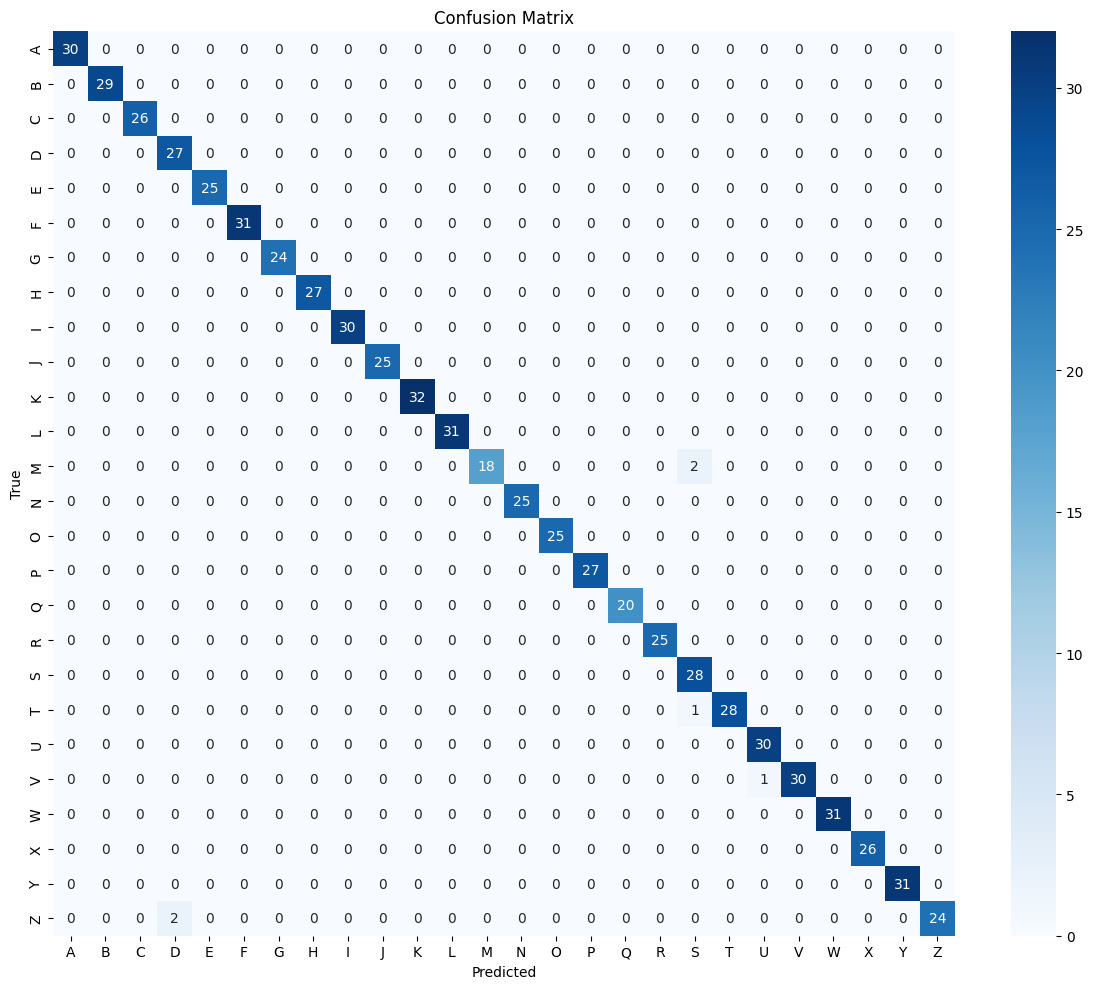


EVALUATION COMPLETE


(99.15611814345992, 0.06912083601848905)

In [ ]:
full_evaluation(model, test_loader, test_dataset.label_encoder)

## Model saving

### Subtask:
Save the trained model to a file.


In [ ]:
# --> ADD THIS TO YOUR TRAINING SCRIPT <--
import pickle

# Save the label encoder from the training dataset
with open('label_encoder.pkl', 'wb') as f:
    pickle.dump(train_dataset.label_encoder, f)
print("✅ Label encoder saved to label_encoder.pkl")

✅ Label encoder saved to label_encoder.pkl
